## Quality assurance of prediction results

In the previous tutorial, we looked at various ways to visualise the results of our model.  

These are useful for quality assurance purposes because they allow us to understand how our model works and verify that it is doing something sensible.  They can also be useful to identify examples where the model is not performing as expected.  

In addition to these spot checks, Splink also has functions to perform more formal accuracy analysis.  These functions allow you to understand the likely prevalence of false positives and false negatives in your linkage models.

They rely on the existence of a sample of labelled (ground truth) matches, which may have been produced (for example) by human beings.  For the accuracy analysis to be unbiased, the sample should be representative of the overall dataset.

In [5]:
# Rerun our predictions to we're ready to view the charts
from splink.duckdb.duckdb_linker import DuckDBLinker
import pandas as pd 
#import altair as alt
#alt.renderers.enable('mimetype')

df = pd.read_csv("./data/fake_1000.csv")
linker = DuckDBLinker(df)
linker.load_settings_from_json("./demo_settings/saved_model_from_demo.json")
df_predictions = linker.predict()#(threshold_match_probability=0.2)

## Load in labels

The labels file contains a list of pairwise comparisons which represent matches and non-matches.

The required format of the labels file is described [here](https://moj-analytical-services.github.io/splink/linkerqa.html#splink.linker.Linker.roc_chart_from_labels).

In [6]:
df_labels = pd.read_csv("./data/fake_1000_labels.csv")
linker.register_table(df_labels, "labels")
linker._initialise_df_concat_with_tf()
df_labels.head(5)

,unique_id_l,source_dataset_l,unique_id_r,source_dataset_r,clerical_match_score
0,0,fake_1000,1,fake_1000,1.0
1,0,fake_1000,2,fake_1000,1.0
2,0,fake_1000,3,fake_1000,1.0
3,0,fake_1000,4,fake_1000,0.0
4,0,fake_1000,5,fake_1000,0.0


In [3]:
df.head(10)

,unique_id,first_name,surname,dob,city,email,cluster
0,0,Robert,Alan,1971-06-24,NaN,robert255@smith.net,0
1,1,Robert,Allen,1971-05-24,NaN,roberta25@smith.net,0
2,2,Rob,Allen,1971-06-24,London,roberta25@smith.net,0
3,3,Robert,Alen,1971-06-24,Lonon,NaN,0
4,4,Grace,NaN,1997-04-26,Hull,grace.kelly52@jones.com,1
5,5,Grace,Kelly,1991-04-26,NaN,grace.kelly52@jones.com,1
6,6,Logan,pMurphy,1973-08-01,NaN,NaN,2
7,7,NaN,NaN,2015-03-03,Portsmouth,evied56@harris-bailey.net,3
8,8,NaN,Dean,2015-03-03,NaN,NaN,3
9,9,Evie,Dean,2015-03-03,Pootsmruth,evihd56@earris-bailey.net,3


In [8]:
df_labels.head(10)

,unique_id_l,source_dataset_l,unique_id_r,source_dataset_r,clerical_match_score
0,0,fake_1000,1,fake_1000,1.0
1,0,fake_1000,2,fake_1000,1.0
2,0,fake_1000,3,fake_1000,1.0
3,0,fake_1000,4,fake_1000,0.0
4,0,fake_1000,5,fake_1000,0.0
5,0,fake_1000,6,fake_1000,0.0
6,0,fake_1000,7,fake_1000,0.0
7,0,fake_1000,8,fake_1000,0.0
8,0,fake_1000,9,fake_1000,0.0
9,0,fake_1000,10,fake_1000,0.0


In [9]:
def get_u_id(left):
    return df_labels[df_labels['unique_id_l']==left].head(3)

pd.concat([get_u_id(0),get_u_id(1),get_u_id(4)],axis=0).reset_index().drop('index',axis=1)

,unique_id_l,source_dataset_l,unique_id_r,source_dataset_r,clerical_match_score
0,0,fake_1000,1,fake_1000,1.0
1,0,fake_1000,2,fake_1000,1.0
2,0,fake_1000,3,fake_1000,1.0
3,1,fake_1000,2,fake_1000,1.0
4,1,fake_1000,3,fake_1000,1.0
5,1,fake_1000,4,fake_1000,0.0
6,4,fake_1000,5,fake_1000,1.0
7,4,fake_1000,6,fake_1000,0.0
8,4,fake_1000,7,fake_1000,0.0


## Receiver operating characteristic curve

A [ROC chart](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) shows how the number of false positives and false negatives varies depending on the match threshold chosen.  The match threshold is the match weight chosen as a cutoff for which pairwise comparisons to accept as matches.



In [10]:
linker.roc_chart_from_labels_table("labels")#,threshold_actual=0.2)

### Precision-recall chart

An alternative representation of truth space is called a [precision recall curve](https://stats.stackexchange.com/questions/7207/roc-vs-precision-and-recall-curves).

This can be plotted as follows:

In [22]:
linker.precision_recall_chart_from_labels_table("labels")

## Truth table

Finally, Splink can also report the underlying table used to construct the ROC and precision recall curves.

In [26]:
linker._initialise_df_concat_with_tf()
linker.roc_chart_from_labels_table("labels")

In [11]:
from sklearn.metrics import auc
roc_table = linker.truth_space_table_from_labels_table("labels")
roc_t = roc_table.as_pandas_dataframe()
auc_score = auc(roc_t['FP_rate'],roc_t['TP_rate'])
print(auc_score)
roc_t

0.9879094362258911


,truth_threshold,match_probability,row_count,P,N,TP,TN,FP,FN,P_rate,N_rate,TP_rate,TN_rate,FP_rate,FN_rate,precision,recall,F1
0,-16.609950,0.000010,1225.0,80.0,1145.0,80.0,0.0,1145.0,0.0,0.0,0.934694,1.0000,0.000000,1.000000,0.0000,0.065306,1.0000,0.122699
1,-15.488604,0.000022,1225.0,80.0,1145.0,80.0,98.0,1047.0,0.0,0.0,0.934694,1.0000,0.085590,0.914410,0.0000,0.070985,1.0000,0.132670
2,-14.677083,0.000038,1225.0,80.0,1145.0,80.0,268.0,877.0,0.0,0.0,0.934694,1.0000,0.234061,0.765939,0.0000,0.083595,1.0000,0.154440
3,-14.535475,0.000042,1225.0,80.0,1145.0,80.0,310.0,835.0,0.0,0.0,0.934694,1.0000,0.270742,0.729258,0.0000,0.087432,1.0000,0.160966
4,-14.078051,0.000058,1225.0,80.0,1145.0,80.0,396.0,749.0,0.0,0.0,0.934694,1.0000,0.345852,0.654148,0.0000,0.096502,1.0000,0.176211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,21.121825,1.000000,1225.0,80.0,1145.0,7.0,1145.0,0.0,73.0,0.0,0.934694,0.0875,1.000000,0.000000,0.9125,1.000000,0.0875,0.162791
94,21.747537,1.000000,1225.0,80.0,1145.0,6.0,1145.0,0.0,74.0,0.0,0.934694,0.0750,1.000000,0.000000,0.9250,1.000000,0.0750,0.139535
95,22.053313,1.000000,1225.0,80.0,1145.0,5.0,1145.0,0.0,75.0,0.0,0.934694,0.0625,1.000000,0.000000,0.9375,1.000000,0.0625,0.119048
96,23.158090,1.000000,1225.0,80.0,1145.0,4.0,1145.0,0.0,76.0,0.0,0.934694,0.0500,1.000000,0.000000,0.9500,1.000000,0.0500,0.095238


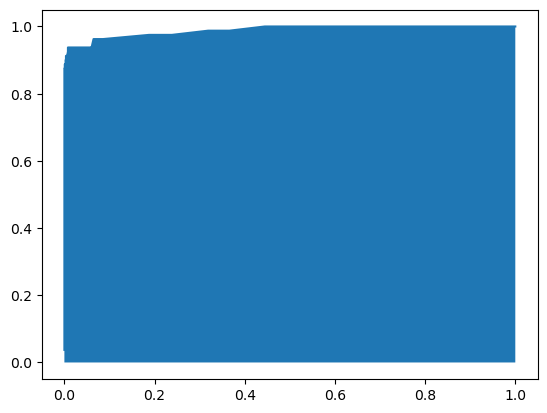

In [45]:
import matplotlib.pyplot as plt
x=roc_t['FP_rate']
y=roc_t['TP_rate']
plt.plot(x,y)
plt.fill_between(x,y)
plt.show()

In [52]:
def auc(x, y):
    area = 0
    for i in range(1, len(x)):
        calculus = np.abs((x[i] - x[i-1]) * (y[i] + y[i-1]) / 2)
        area += calculus
    return area

x=roc_t['FP_rate']
y=roc_t['TP_rate']

auc(x,y)

0.9879093946074136

In [54]:
from sklearn.metrics import auc as AAUC

AAUC(x,y)

0.9879094362258911